In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from einops import rearrange, repeat

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
# mushroom
from mushroom.mushroom import Mushroom
import mushroom.data.xenium as xenium
import mushroom.data.visium as visium
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [5]:
dtype_to_chkpt = {
    'xenium': '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/xenium_HT413C1_Th1k4A1_v1/outputs/chkpts/last-v1.ckpt',
    'he': '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/he_HT413C1_Th1k4A1_v1/outputs/chkpts/last.ckpt',
    'multiplex': '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/multiplex_HT413C1_Th1k4A1_v1/outputs/chkpts/last.ckpt'
}
dtype_to_config = {
    'xenium': '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/xenium_HT413C1_Th1k4A1_v1/outputs/chkpts/mushroom_config.yaml',
    'he': '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/he_HT413C1_Th1k4A1_v1/outputs/chkpts/mushroom_config.yaml',
    'multiplex': '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/multiplex_HT413C1_Th1k4A1_v1/outputs/chkpts/mushroom_config.yaml',
}

In [7]:
dtype_to_mushroom = {k:Mushroom.from_config(
    dtype_to_config[k],
    chkpt_filepath=dtype_to_chkpt[k],
    accelerator='cpu'
) for k in dtype_to_chkpt.keys()}

INFO:root:starting xenium processing
INFO:root:using 477 channels
INFO:root:5 sections detected: ['s2', 's5', 's9', 's13', 's21']
INFO:root:processing sections
INFO:root:generating image data for section s2
INFO:root:generating image data for section s5
INFO:root:generating image data for section s9
INFO:root:generating image data for section s13
INFO:root:generating image data for section s21
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 5 sections detected: [('s2', 'xenium'), ('s5', 'xenium'), ('s9', 'xenium'), ('s13', 'xenium'), ('s21', 'xenium')]
INFO:root:creating data loaders
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpbjtc4fcc
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpbjtc4fcc/_remote_module_non_scriptable.py
INFO:root:creating ViT
INFO:root:model initialized
wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/htan_talk/mushroom/xenium_HT413C1_Th1k4A1_v1/outputs/chkpts/last-v1.ckpt
INFO:root:starting he processing
INFO:root:14 sections detected: ['s0', 's1', 's4', 's7', 's8', 's10', 's11', 's12', 's15', 's16', 's17', 's20', 's23', 's24']
INFO:root:processing sections
INFO:root:generating image data for section s0
INFO:root:generating image data for section s1
INFO:root:generating image data for section s4
INFO:root:generating image data for section s7
INFO:root:generating image data for section s8
INFO:root:generating image data for section s10
INFO:root:generating image data for section s

In [8]:
for dtype, mushroom in dtype_to_mushroom.items():
    mushroom.embed_sections()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

In [24]:
order = sorted(dtype_to_mushroom.keys())
order

['he', 'multiplex', 'xenium']

In [25]:
volumes = Mushroom.generate_multi_interpolated_volume([dtype_to_mushroom[k] for k in order], z_scaler=.1)

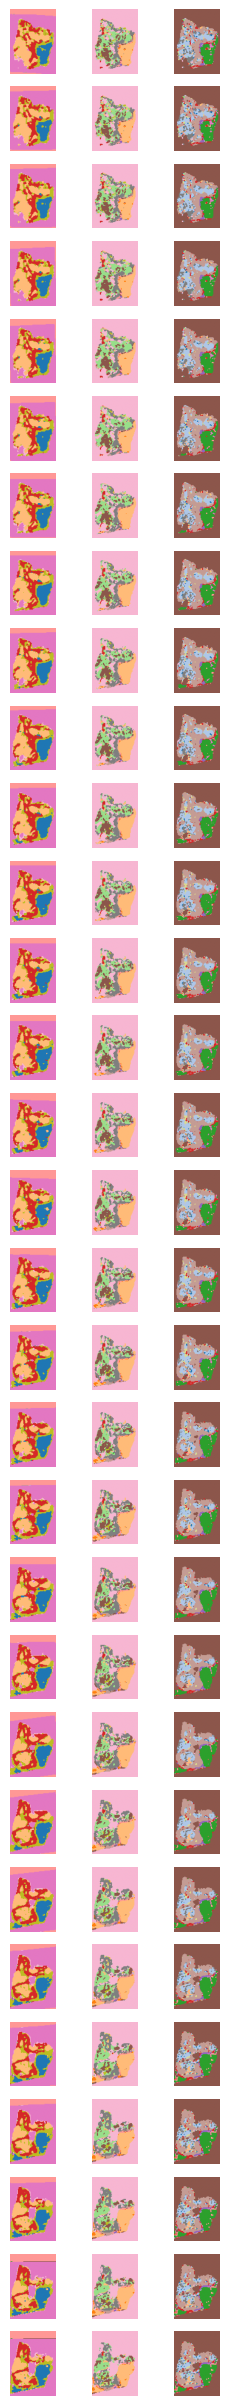

In [26]:
fig, axs = plt.subplots(nrows=volumes[0].shape[0], ncols=len(volumes), figsize=(len(volumes), volumes[0].shape[0]))
for i in range(volumes[0].shape[0]):
    for j, volume in enumerate(volumes):
        ax = axs[i, j]
        rgb = vis_utils.display_labeled_as_rgb(volumes[j][i], preserve_indices=True)
        ax.imshow(rgb)
        ax.axis('off')

In [27]:
def relabel_merged_volume(merged):
    clusters, counts = rearrange(merged, 'n h w z -> (n h w) z').unique(dim=0, return_counts=True)
    int_to_cluster = [tuple(x.numpy()) for i, x in enumerate(clusters)]
    cluster_to_int = {x:i for i, x in enumerate(int_to_cluster)}
    
    new = torch.zeros(merged.shape[:3], dtype=torch.long)
    for i, cluster in enumerate(clusters):
        mask = (merged == cluster).sum(-1) == len(cluster)
        new[mask] = i
    
    return new, int_to_cluster

def merge_volumes(volumes, are_probs=False, kernel=None):
    if kernel is None:
        kernel = torch.full((3,3,3), .2)
        kernel[1,1,1] = 1.
        stamp = rearrange(kernel, 'n h w -> 1 1 1 1 n h w')
    
    if not are_probs:
        hots = [F.one_hot(torch.tensor(v)) for v in volumes]

        probs = []
        for hot in hots:
            hot = hot.unfold(0, 3, 1)
            hot = hot.unfold(1, 3, 1)
            hot = hot.unfold(2, 3, 1)
            out = (hot * stamp).sum(dim=(-3, -2, -1))
            out /= out.max()
            probs.append(out)
    else:
        probs = [torch.tensor(v) for v in volumes]
        
    x = torch.einsum('nhwa,nhwb,nhwc->nhwabc', *probs)
    flat_x = rearrange(x, 'n h w ... -> n h w (...)')
    idxs = flat_x.argmax(-1)
    values = flat_x.max(-1).values
    
    meshes = torch.meshgrid(torch.arange(x.shape[-3]), torch.arange(x.shape[-2]), torch.arange(x.shape[-1]))
    flat_meshes = torch.stack([mesh.flatten() for mesh in meshes])
    objs = flat_meshes[:, idxs.flatten()]
    
    n, h, w = x.shape[:3]
    final = rearrange(objs, 'c (n h w) -> n h w c', n=n, h=h, w=w)
    
    new, int_to_cluster = relabel_merged_volume(final)
    
    new = F.pad(new, (1,1,1,1,1,1), value=-1)
    values = F.pad(values, (1,1,1,1,1,1), value=0.)
    
    return new.numpy(), values.numpy(), int_to_cluster

In [28]:
labeled, values, label_to_cluster = merge_volumes(volumes)
labeled.shape, values.shape, len(np.unique(labeled)), len(label_to_cluster)

((31, 108, 76), (31, 108, 76), 670, 669)

In [29]:
cluster_to_value = {}
for c in np.unique(labeled):
    mask = labeled==c
    cluster_to_value[c] = values[mask].sum()
cluster_to_value

{-1: 0.0,
 0: 0.42919007,
 1: 0.6501293,
 2: 0.2696117,
 3: 0.101507194,
 4: 0.8963783,
 5: 0.23201647,
 6: 0.0573999,
 7: 0.15951127,
 8: 0.24937068,
 9: 5.9830837,
 10: 0.7111546,
 11: 2.997114,
 12: 10.072037,
 13: 8.64889,
 14: 1.3042196,
 15: 36.507378,
 16: 12.897757,
 17: 60.37559,
 18: 0.08609985,
 19: 1.1725692,
 20: 1.2481962,
 21: 0.45355988,
 22: 2.5200903,
 23: 157.44339,
 24: 0.09700919,
 25: 0.5249573,
 26: 1.1767986,
 27: 14.797256,
 28: 0.51304096,
 29: 0.0872747,
 30: 0.16327083,
 31: 1.2010007,
 32: 2.5333834,
 33: 0.18696924,
 34: 61.408356,
 35: 0.22825691,
 36: 1.3650435,
 37: 6.4070373,
 38: 30.72113,
 39: 6.7656693,
 40: 33.624863,
 41: 28.013065,
 42: 376.5592,
 43: 15053.912,
 44: 33.69089,
 45: 87.63417,
 46: 0.12184891,
 47: 1.1524287,
 48: 26.805717,
 49: 0.5931323,
 50: 0.06485181,
 51: 0.13292609,
 52: 0.6493573,
 53: 1.5466086,
 54: 35.80871,
 55: 0.038400866,
 56: 1.3315436,
 57: 1.4699411,
 58: 76.003044,
 59: 8.04515,
 60: 3.3245282,
 61: 1.9150083,
 

In [61]:
dtype_to_cluster_dists = {}
for dtype, mushroom in dtype_to_mushroom.items():
    df = mushroom.get_cluster_intensities(level=-1)[dtype]
    data = torch.cdist(torch.tensor(df.values), torch.tensor(df.values)).numpy()
    data /= data.std()
    dtype_to_cluster_dists[dtype] = data

In [62]:
for k, v in dtype_to_cluster_dists.items(): print(k, v.shape)

xenium (28, 28)
he (17, 17)
multiplex (31, 31)


In [47]:
order

['he', 'multiplex', 'xenium']

In [70]:
label_to_cluster[0], label_to_cluster[14]

((0, 3, 1), (0, 13, 1))

In [71]:
label_to_cluster[0], label_to_cluster[19]

((0, 3, 1), (0, 14, 1))

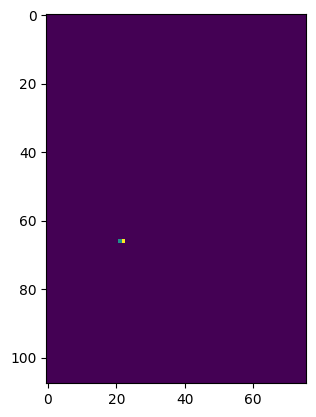

In [72]:
plt.imshow((labeled==0).sum(0))

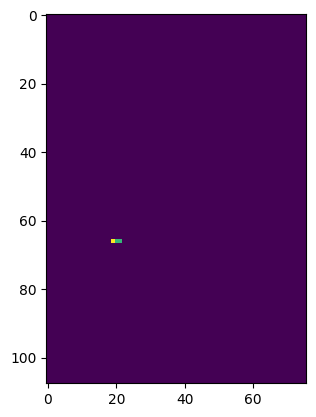

In [73]:
plt.imshow((labeled==14).sum(0))

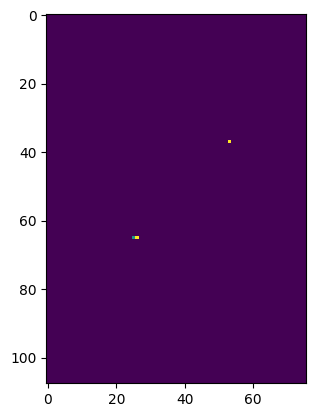

In [77]:
plt.imshow((labeled==25).sum(0))

In [160]:
# max_edges = 100
thresh = .5
edges, weights = [], []
for label_a in range(labeled.max()):
    cluster_a = label_to_cluster[label_a]
    node_edges = []
    for label_b in range(labeled.max()):
        cluster_b = label_to_cluster[label_b]
        
        dist = 0.
        if label_a != label_b:
            for dtype, ca, cb in zip(order, cluster_a, cluster_b):
                dist += dtype_to_cluster_dists[dtype][ca, cb]
        dist /= len(order)
                
        if dist > 0.:
            node_edges.append([label_a, label_b, dist])
    
    es = sorted(node_edges, key=lambda x:x[-1], reverse=False)
    weights += [val for _, _, val in es if val<=thresh]
    edges += [[a, b] for a, b, val in es if val<=thresh]
weights = np.asarray(weights)
edges = np.asarray(edges)
    
len(edges), edges[:5], weights[:5]

(16028,
 array([[  0, 475],
        [  0, 217],
        [  0, 647],
        [  0,  46],
        [  0, 467]]),
 array([0.08514333, 0.18654833, 0.21616432, 0.2458474 , 0.25497907]))

In [161]:
weights.max()

0.49997012813886005

In [162]:
import igraph
g = igraph.Graph()
g.add_vertices(labeled.max() + 1)
g.add_edges(edges)

In [171]:
results = g.community_leiden(weights=weights, resolution=2., n_iterations=100, objective_function='modularity')

In [172]:
results.summary()

'Clustering with 669 elements and 16 clusters'

In [173]:
to_relabeled = {i:c for i, c in enumerate(results.membership)}
to_relabeled[-1] = -1

In [174]:
labeled.max()

668

In [175]:
relabeled = np.vectorize(to_relabeled.get)(labeled)

In [176]:
# results.membership

In [177]:
relabeled.shape

(31, 108, 76)

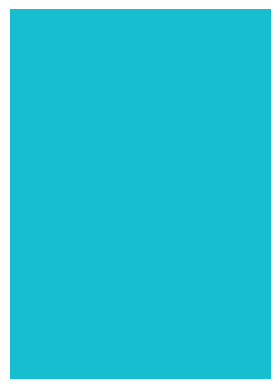

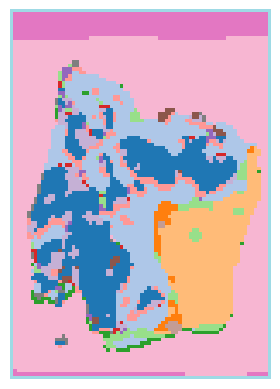

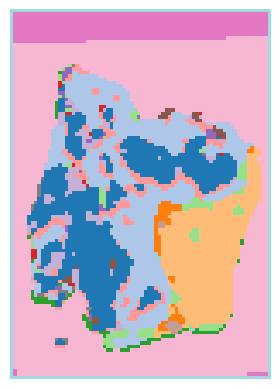

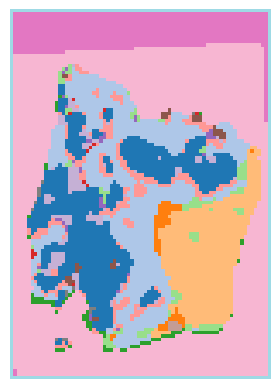

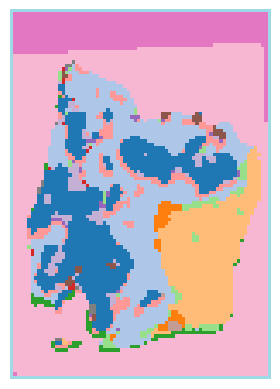

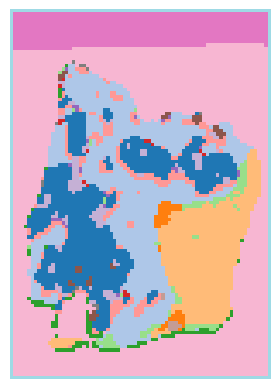

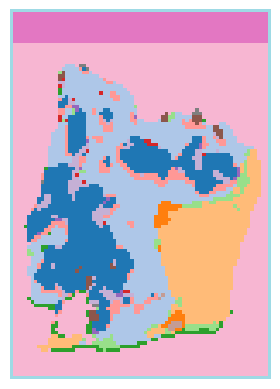

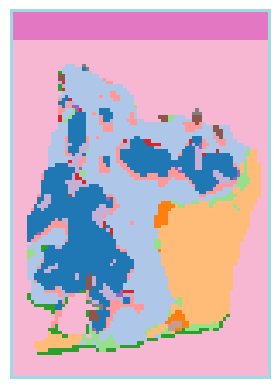

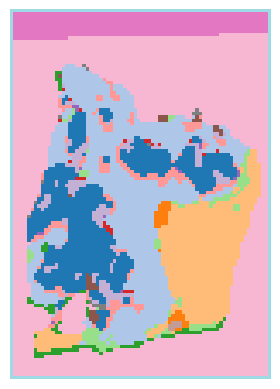

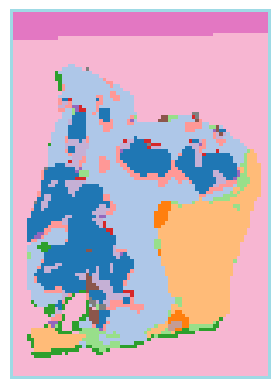

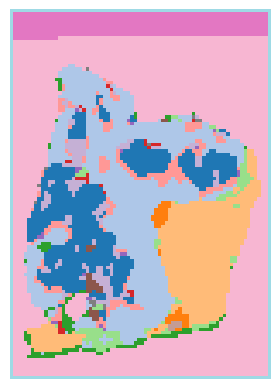

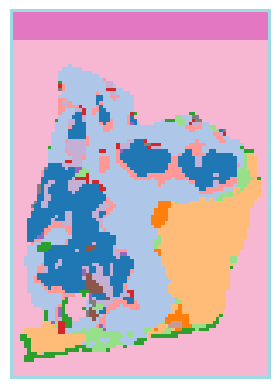

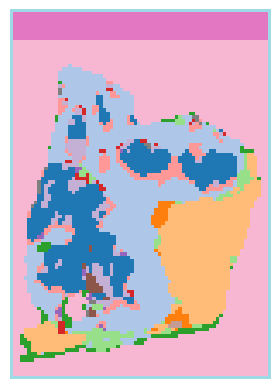

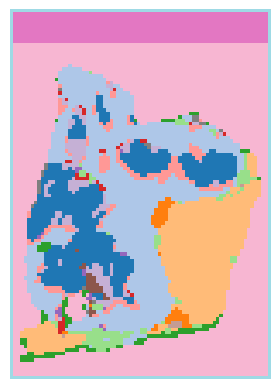

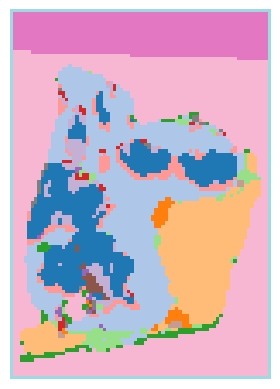

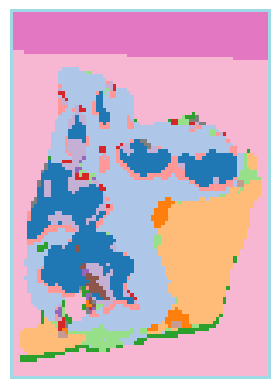

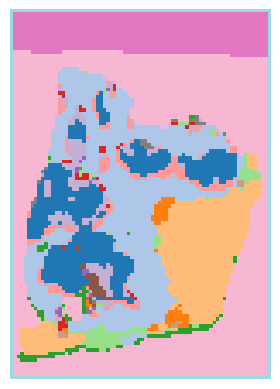

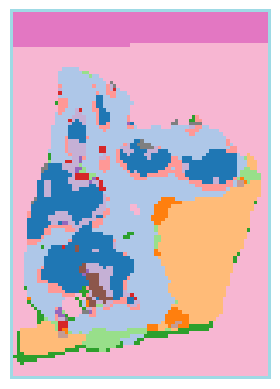

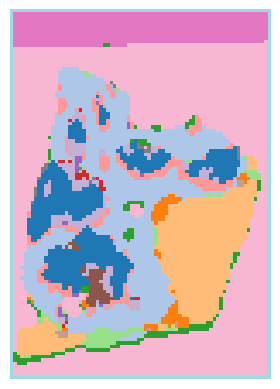

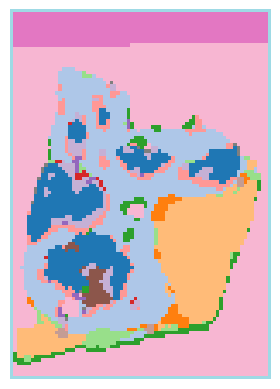

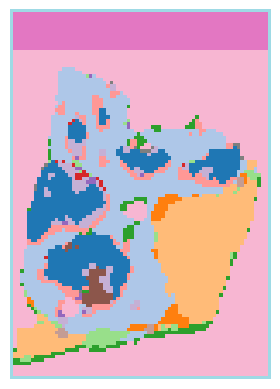

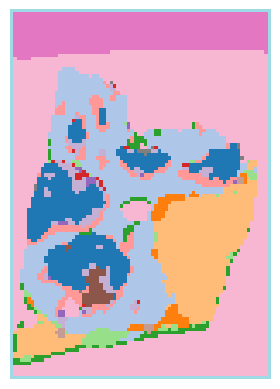

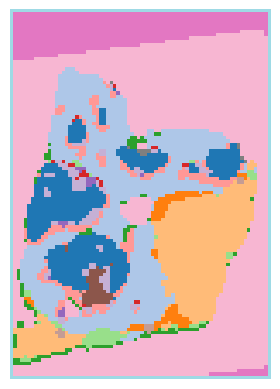

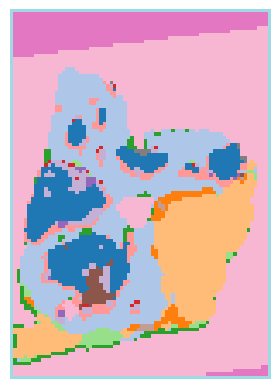

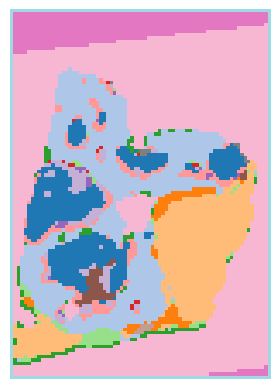

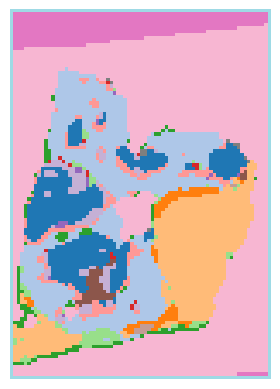

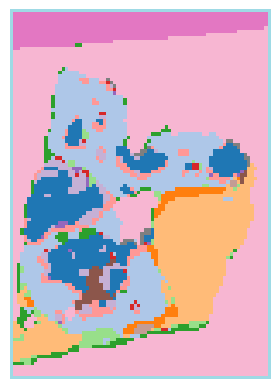

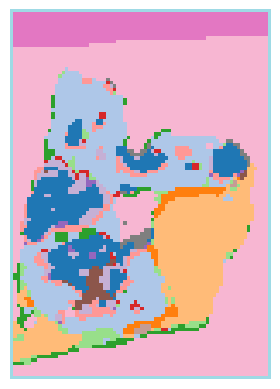

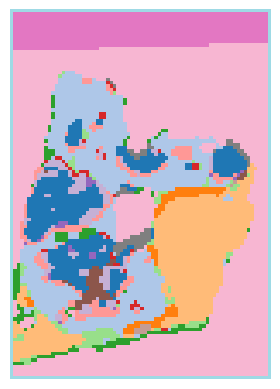

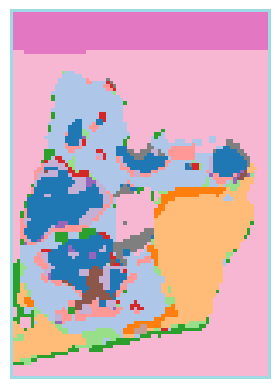

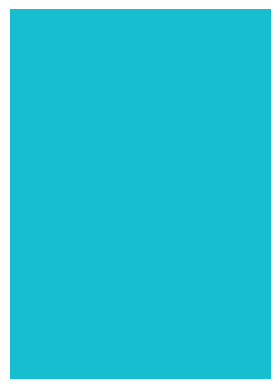

In [178]:
for x in relabeled:
    rgb = vis_utils.display_labeled_as_rgb(x, preserve_indices=True)
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()
    